# Data Processing Write-up

## Abstract

The dark web is notoriously difficult to crawl. The Hidden Services directory, which users use to find hidden services, stores hashes of domains to prevent enumeration. Enthusiasts have taken steps to make the dark web more well-known, whether it is through status sites or just posting news regarding the dark web. The process to do so often requires manual enumeration of dark web sites to determine what service they offer and how to access it. Most of the sites availble focus on the markets of the dark web, nor are generally safe if you utilize anti-virus. This project aims to create a dark web crawler to automate the process of finding hidden service URLs on the clear web, and have the results accessible on the clear web. This was done utilizing the Python programming language to parse the Common Crawl Corpus for dark web domains, connect to each domain, and display the results on a Flask app that everyone can access. The efforts outlined in this paper focuse on the big data analysis portion and performing a basic analysis of the top 10 most frequently discovered domains. From the Common Crawl Corpus (for the month of September) 40,239 unique dark web domains were discovered accross 6443 clear web domains. Future work is needed to enable automatic classification of each dark web site.

## Introduction
Public awareness of the dark web has risen the past few years with the take down of the Silkroad market by the FBI and the rise in ransomware attacks. Hidden services, the web sites hosted on the dark web, are not highly connected through hyperlinks like sites on the clearweb, reducing the ability of a user to index the dark web. These services do not use typical Domain Name Service (DNS) resolution; instead a hash of the machine is used in place of the domain name that a user must know to access the service. This hash is typically found either via fellow dark web users or via certain sites on the clear web. 
A hidden service is often denoted with a .onion top level domain, provided by The Onion Router (TOR) project. To access a service you have to use the TOR browser and have the hash of said hidden service. As previously stated these hashes could be discovered on typical clear web sites such as Reddit or on dark web-oriented sites such as darknetstats.com or deeponionweb.com. It is usually tedious and sometimes unsafe to manually search the clear web for onions, as some of the sites (i.e. darknetstats.com) raise alerts with anti-virus. A safer method would be to use open-sourced data to search for hidden services and try to rank clear web sites by the amount of unique dark web domains found on each one.

## Technologies
To begin, we first sought to find a safe method to gather data on the clear web, without having to crawl it ourselves. The Common Crawl organization each month runs a crawler to index the clear web. The organization then saves their findings to compressed warc.wet files. Each file contains multiple indexed websites along with the content that is hosted on them. The warc.wet files were optimal as they were not only smaller than the .wet files, but they also provided only the plaintext extracted from the source code, which removed the concern that the script will have to filter out HTML code which would increase the speed and size of the script. These files have the specified format outlined in Figure 1.
![](Final_Images/cc_format.png)
*__Figure 1__: Common Crawl file format*


The Common Crawl corpus is hosted via Amazon Web Services (AWS), thus we had to download the scripts utilizing wget. The corpus we used was from September of 2019, keep in mind the goals of this project was being developed in late 2019, but waited until the start of the second semester to begin in full swing. All of the common crawl files were saved to a Linux cluster owned by Major (MAJ) Daniel Hawthorne. For this project, the cluster allocated 8 GB RAM, 10 TB of storage, and 8 threads. All of the files summed up to 8.9 TB in total, leaving 1.1 TB left for anything we need. The programming language that we decided to use was Python. This was due to the extensive library it provided and that it was the only programming language I was comfortable with. The last piece of technology that was utilized was Aquamentus. Aquamentus is Linux computer system that features: 14 TB Solid State Drive (SSD), 128 GB RAM, and 32 threads. This is another system built and owned by MAJ Hawthorne that run the final scripts against the common crawl files. 

## Methodology
The methodology to process the data first begins with the Common Crawl. The Common Crawl crawls the web each month and saves the results to a GZipped Warc-Wet file. The python script will query the common crawl for the monthly data and save it to the local machine. Once all of he files are saved, the script will open the number of processors relative to  the available RAM on the machine. The script will determine how many files need to be parsed, and allocate an even amount to each processor. Next it will open the file and search for dark web sites utilizing a regular expression. Once a dark web site is found the site along with the clear web site it was found on are written to a CSV. The CSV has the name of the corresponding file that is open to help track sites. Once the script is finished parsing each file, another script starts up where it combines all the CSVs into one dump file. The script will then count the unique dark web and clear web sites and output them to two separate CSVs for analysis. The following will be described in the next few paragraphs: development of the regular expression, onion finder script, and the counter script.

## Regular Expression Development
1. (?:https?\:\/\/)?[a-zA-Z2-7]{16}\.onion?(?:\/([^/]*))?$ (Intitial)
2. (?:https?\:\/\/)?[a-zA-Z2-7]{16}\.onion?(?:\/([^/\s]*))? (Accounts for whitepsace)
3. [a-zA-Z2-7]{16}\.onion?(?:\/([^/ \s]*))? (No longer searches for www, htttp, https)
4. [a-zA-Z2-7]{16}\.onion?(?:\/([^/ \\\s]*))? (Attempt to remove \r \n \t characters)
    a. Started to compile regex once to improve performance
5. [a-zA-Z2-7]{16}|[a-zA-Z2-7]{56})\.onion?(?:\/([^/ \\\s]*))? (Searches for v2 and v3 onions) (FINAL: NO LONGER SUCKS!! :))

## Onion Finder Development
The onion finder script focused on parsing each common crawl file for darkweb domains and recording the clearweb site it was discovered on. The first task that needed to be accomplished was development of the regular expression (regex). The regular expression had to match strings with the specifications of a valid onion domain. According to specifications from the TOR project, a valid onion is 16 characters in length that is comprised of any letter and number from 2 until 7. Since we wanted to extract the complete onion address the initial regular expression was: 

(?:https?://)?[a-zA-Z2-7]{16}.onion?(?:/([^/]*))?$

To validate that this expression worked, it was inputted into the online regex tester at https://regex101.com along with randomly generated valid and invaid onion domains that meet the specifications. The result from this test showed that the regex would find the onion domain and take everything that occurred after the domain, including spaces. This would skew results as it would return the rest of the file once it found a domain in the common crawl. To remediate the error, the regex was updated to account for whitespace:

(?:https?://)?[a-zA-Z2-7]{16}.onion?(?:/([^/\s]*))?

The patch was verified with the online regex tester, however running the regex on a local file, the regex extracted various string literals such as tab and return characters. We also determined that it was unecessary to check for the protocol (HTTP/HTTPS) or www in the URL for the following reasons: 1/TOR only uses HTTPS by default so checking for the protocol is pointless. 2/ onions cannot be accessed from the clear web, so www will only generate errors when connecting to the service. With these two new determinations, the regex was shortened to:

[a-zA-Z2-7]{16}.onion?(?:/([^/ \\s]*))?

The final regex came after the discovery that TOR plans to start implementing what it called v3 onions. v3 onions use a longer hash length of 56 to not only improve security but to expand the space available on the dark web. We originally only checked for v2 onions that were 16 characters long. As such we once again updated the regex to its final form:

[a-zA-Z2-7]{16}|[a-zA-Z2-7]{56}).onion?(?:/([^/ \\s]*))?

the next step was to develop the script itself. Initial success was with the warc3-wet library written by William Zhang. This library while simple to use was not efficient in terms of speed. For the seven test files utilized on a local machine, it took the script 189 seconds to complete. This did not seem too bad, however once the calculations were done to estimate the time it would take to parse through 55985 files, it would have taken approximately 17.5 days for the script to run. Since this was the initial test phase, this was run on the cluster hosted by MAJ Hawthorne where it did in fact take 2.5 weeks. From that run, 5400 unique dark web domains were discovered accross 5689 clear web sites. After this, the common crawl files were transferred over to Aquamentus for further testing. To verify the accuracy of the script, Mr. King ran a Ruby script which utlized the Java file stream library. With his script, he found 39,838 unique dark web sites over 6,393 clear web domains. Confused as to why his script found substantially more than mine did. After reviewing the code I believe the culprit to be the re.search method. Attempts were made to modify the script to use re.findall, however for some reason failed to capture the full string. A quick review of Python's documentation lead to my discovery that re.search returns only the first instance, so it was not even completely parsing each file. To remidiate this, I ended up creating a separate function that generates dark web domains with the regular expression, instead of just calling it on the content itself.

Running the script again on my local files, it did find substantially more dark web sites but still took unecessarily long to do so. A review of the warc library showed that it was written with an emphasis on ease of use and not speed. Searching Google, I learned that Common Crawl files could be read usnig the gzip and io libraries, both of which are native to python. These libraries fed provided data line-by-line, which eliminated the need for the generator function. Re-writing the script this way decreased the time it took to parse the 7 files from 189 seconds down to 98 seconds. At 16 processors, this equated to approximately 9 days. See Figure 2 for the speed test results. At this time, we were ready to run the script on Aquamentus.

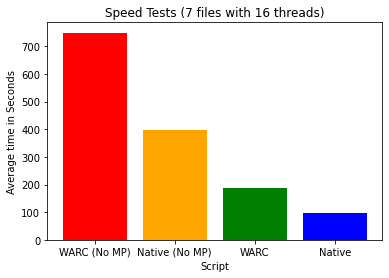

In [13]:
import matplotlib.pyplot as plt
wmp = 189
wnmp = 749
nmp = 98
nnmp = 396
plt.bar("WARC (No MP)", wnmp, color='red')
plt.bar("Native (No MP)", nnmp, color='orange')
plt.bar("WARC", wmp, color='green')
plt.bar("Native", nmp, color='blue')
plt.xlabel('Script')
plt.ylabel('Average time in Seconds')
plt.title('Speed Tests (7 files with 16 threads)')
plt.show()

*__Figure 2__: Speed Tests*


## Counter development

Development of the counters did nor require as much troubleshooting as the onion finder did. The initial thought process was to pull the onions and websites from each CSV into another CSV. In that CSV the counts from each individual CSV were compiled; next the script opned that file and took any duplicate domain and its associated count and combined them. This removed all duplicates from the file but preserved the counts. The script then went through and sorted each domain by its count. The process was then repeated for the clear web sites. The method was not pretty, but got the job done. After further research and with help from Mr. King, the script was drastically minimized. This was done by forcing the script to compile all the CSVs into one dump file. The script will then use the pandas library to identify and remove duplicate domains and combine their counts. It then sorted the domains and saved the results to a another CSV.

### Results

The scripts ran on Aquamentus for approximatley 4 days. From the September Common Crawl Corpus, 40239 unique onion doains were discovered accross 6443 unique clear web sites. This was a 348% increase from the very first run with provided 5400 domains, and a 4% increase from the script Mr. King ran. This was likely due to my script checking the URL itself for onions as well as the extracted content. Out of the 40239 unique domains, 32966 were v2 domains and 7273 were v3 domains. TOR maintains a metric counting the amount of unique v2 domains on their network. The month of September had approximatley 75000 active domains. This means we found about 44% of the active domains that were active (See Figure 3 for a visualized comparison). 

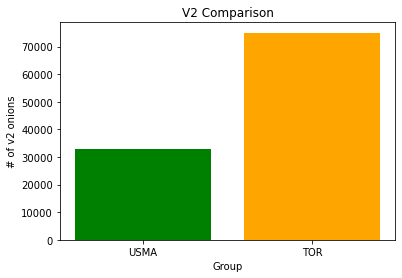

In [7]:
import matplotlib.pyplot as plt
usma = 32966
tor = 75000
plt.bar("USMA", usma, color='g')
plt.bar("TOR", tor, color='orange')
plt.xlabel('Group')
plt.ylabel('# of v2 onions')
plt.title('V2 Comparison')
plt.show()

*__Figure 3__: Visual comparison*

From the CSV that provided the counts, the top ten onion domains were: 

1.	hydraruzxpnew4af.onion
2.	facebookcorewwwi.onion
3.	hydraruz4afxpnew.onion
4.	3g2upl4pq6kufc4m.onion
5.	probiv7jg46vmbox.onion
6.	wayawaytcl3k66fl.onion
7.	uj3wazyk5u4hnvtk.onion
8.	hydra5etioavaz7p.onion
9.	xmh57jrzrnw6insl.onion


## Dark Web Rudimentary Analysis


Analyzing the top ten site involved navigating to the domain, interacting with the site, and querying google for extra information. This was done by utlizing a virutal machine (VM) with the Whonix OS. Whonix is a Linux distribution that focuses on anonymizing all of your web traffic and providing maximum security. This OS is safer when connecting to unknown onion sites due to its ability to 'sandbox' all applications, so should malware be installed it will be unable to determine the IP address of the host system.

Out of the ten domains, three failed to connect after multiple attempts, one was classified as adware, and the remaining six were sites for illegal activities. the following figures are screenshots of what each domain returned along with a short description.

### hydraruzxpnew4af.onion, hydra5etioavaz7p.onion, hydra6c2bnrd6phf.onion
![](Final_Images/hydraetio.png)
![](Final_Images/hydraref.png)

*__Figure 4__: Hydra market*


Hydra is a the top Russian marketplace on the darknet and very famous amount Russian speaking community. Hydra opened in 2015, providing a marketplace for illegal goods such as drugs and their ingredients, counterfeit documents and money, and hacking services. There is a reference at the bottom of each page, listing out the 7 active Hydra domains. There may be 7 as a remediation effort to keep their services up, should law enforcement seize the domain or should a hacker destroy it.

### facebookcorewwwi.onion
![](Final_Images/fb.png)

*__Figure 5__: First failure*

This is the dark web site for the Facebook. Has the same functionality as the clear web version, except all your traffic is encrypted.

### hydraruz4afxpnew.onion
![](Final_Images/hydraruz4af.png)

*__Figure 6__: First failure*

This dark web address provides a connection error. This could be due to one of three things: it does not exist, does not run on port 80, exists but is currently offline.

### 3g2upl4pq6kufc4m.onion
![](Final_Images/3g2.png)

*__Figure 7__: DuckDuckGo*

This is the dark web site for the DuckDuckGo search engine. Has the same functionality as the clear web version, except all your traffic is encrypted.

### probiv7jg46vmbox.onion
![](Final_Images/probiv.png)

*__Figure 8__: Probiv*

Probiv is a Russian-language slang term best translated as “look-up”. This dark web domain focuses on the distribution of personally identifiable information (PII) for a price. Primary users are criminals and private investigators.

### wayawaytcl3k66fl.onion
![](Final_Images/wayaway.png)

*__Figure 9__: Second failure*

This dark web address provides a connection error. This could be due to one of three things: it does not exist, does not run on port 80, exists but is currently offline.

### uj3wazyk5u4hnvtk.onion
![](Final_Images/uj3.png)

*__Figure 10__: Third failure*

This dark web address provides a connection error. This could be due to one of three things: it does not exist, does not run on port 80, exists but is currently offline.

### xmh57jrzrnw6insl.onion
![](Final_Images/xmh.png)

*__Figure 11__: TORCH*

Torch or TorSearch is at search engine for the dark web. They claim to be the best, oldest, and longest running search engine for the dark web. This search engine is only available at the dark web address above and via the TOR browser're also the oldest and longest running search engine on Tor. This site is also classified as adware.

## Acknlowedgements

* Mr. Kyle King (NSA)
* MAJ Daniel Hawthorne (U.S. Army)

# Not sure how/if these are necessary. This was an attempt at a timeline of code development. May just remove it and link to the github.

#### Python libraries that were initially used

In [ ]:
import re # Regular expression library
import warc # warc3-wet. To read common crawl files.
import csv # Output and input format
from glob import glob # To find all files in specified directory
from multiprocessing import Pool, cpu_count # To utilize multiple processors to speed up the script
from subprocess import Popen, PIPE # Make the script universal
from sys import platform # Determine system
from os.path import splitext # Used in tracking

##### Regex compile

In [ ]:
# Regex for onions 
# onion_regex = r'([a-zA-Z2-7]{16}|[a-zA-Z2-7]{56})\.onion?(?:\/([^/ \\\s]*))?'
onion_regex = r'(?:[a-zA-Z2-7]{16}|[a-zA-Z2-7]{56})\.onion'
onion = re.compile(onion_regex, re.IGNORECASE)

#### Determine number of processors

In [ ]:
# Determine OS and number of processes to use
def os_processes():
    MAX_PROCESSES = 0
    if platform == "linux" or platform == "linux2":
        # linux
        bashCommand = "nproc"
        process = Popen(bashCommand.split(), stdout=PIPE)
        output, error = process.communicate()
        MAX_PROCESSES = int(output.decode().strip())
    elif platform == "darwin":
        # OS X
        bashCommand = "nproc"
        process = Popen(bashCommand.split(), stdout=PIPE)
        output, error = process.communicate()
        MAX_PROCESSES = int(output.decode().strip())
    elif platform == "win32":
        # Windows
        MAX_PROCESSES = cpu_count()
    return MAX_PROCESSES

### Attempt 1 (initial)

#### Find Onions

In [ ]:
# Find onions in data
def find_onions(filename):
    global onion
    with warc.open(filename) as f:
        with open("{}.csv".format(filename.strip(".warc.wet.gz")), 'w', newline='') as output:
            writer = csv.writer(output)
            writer.writerow(["Site", "Onion"])
            for record in f:
                url = str(record.header.get('WARC-Target-URI', None))
                data = str(record.payload.read())
                url_match = re.search(onion, url)
                payload_match = re.search(onion, data)
                if url_match:
                    onions = list(url_match)
                    for o in onions:
                        writer.writerow([url, o])
                if payload_match:
                    onions = list(payload_match)
                    for o in onions:
                        writer.writerow([url, o])

### Attempt 2

#### Generator

In [ ]:
def findall(pattern, string):
    while True:
        match = re.search(pattern, string)
        if not match:
            break
        yield match.group(0)
        string = string[match.end():]

#### Updated Find Onions

In [ ]:
# Find onions in data
def find_onions(filename):
    global onion
    with warc.open(filename) as f:
        with open("{}.csv".format(filename.strip(".warc.wet.gz")), 'w', newline='') as output:
            writer = csv.writer(output)
            writer.writerow(["Site", "Onion"])
            for record in f:
                url = str(record.header.get('WARC-Target-URI', None))
                data = str(record.payload.read())
                url_match = findall(onion, url)
                payload_match = findall(onion, data)
                if url_match:
                    onions = list(url_match)
                    for o in onions:
                        writer.writerow([url, o])
                if payload_match:
                    onions = list(payload_match)
                    for o in onions:
                        writer.writerow([url, o])

### Attempt 3 (current)

#### Updated libraries (warc removed)

In [ ]:
import re # Regular expression library
import gzip # Read the warc files
import csv # Output and input format
from io import BufferedReader # Speed improvement
from glob import glob # To find all files in specified directory
from multiprocessing import Pool, cpu_count # To utilize multiple processors to speed up the script
from subprocess import Popen, PIPE # Make the script universal
from sys import platform # Determine system
from os.path import splitext # Used in tracking

#### Final find onions

In [ ]:
# Find onions in data
def find_onions(filename):
    global onion
    gz = gzip.open(filename, 'rb')
    f = BufferedReader(gz)
    clear = ''
    with open("{}.csv".format(filename.strip(".warc.wet.gz")), 'w', newline='') as output:
        writer = csv.writer(output)
        for line in f:
            url = re.search(r'WARC-Target-URI: (.+)\r\n', line.decode('utf8'))
            if url:
                clear = url
            domain = re.search(onion, line.decode('utf8'))
            if domain:
                writer.writerow([domain.group(0), clear.group(1)])
    gz.close()

### Main script

In [ ]:
if __name__ == "__main__":
    files = glob("*.warc.wet.gz")
    completed = glob("*.csv")
    completed = [splitext(c)[0] for c in completed]
    if completed:
        files = [f for f in files if f.strip(".warc.wet.gz") not in completed]
    if len(files) == 0:
        print("All Common Crawl Files have been searched!")
    else:
        processors = os_processes()
        print("Searching for onions.........")
        pool = Pool(processors)
        pool.map(find_onions, files)
        pool.close()

### Final onion_finder.py

In [ ]:
import re # Regular expression library
import gzip # Read the warc files
import csv # Output and input format
from io import BufferedReader # Speed improvement
from glob import glob # To find all files in specified directory
from multiprocessing import Pool, cpu_count # To utilize multiple processors to speed up the script
from subprocess import Popen, PIPE # Make the script universal
from sys import platform # Determine system
from os.path import splitext # Used in tracking

# Regex for onions 
# onion_regex = r'(?:https?\:\/\/)?[a-zA-Z2-7]{16}\.onion?(?:\/([^/]*))?'
onion_regex = r'(?:[a-zA-Z2-7]{16}|[a-zA-Z2-7]{56})\.onion'
onion = re.compile(onion_regex, re.IGNORECASE)

# Determine OS and number of processes to use
def os_processes():
    MAX_PROCESSES = 0
    if platform == "linux" or platform == "linux2":
        # linux
        bashCommand = "nproc"
        process = Popen(bashCommand.split(), stdout=PIPE)
        output, error = process.communicate()
        MAX_PROCESSES = int(output.decode().strip())
    elif platform == "darwin":
        # OS X
        bashCommand = "nproc"
        process = Popen(bashCommand.split(), stdout=PIPE)
        output, error = process.communicate()
        MAX_PROCESSES = int(output.decode().strip())
    elif platform == "win32":
        # Windows
        MAX_PROCESSES = cpu_count()
    return MAX_PROCESSES

# Find onions in data
def find_onions(filename):
    global onion
    gz = gzip.open(filename, 'rb')
    f = BufferedReader(gz)
    clear = ''
    with open("{}.csv".format(filename.strip(".warc.wet.gz")), 'w', newline='') as output:
        writer = csv.writer(output)
        for line in f:
            url = re.search(r'WARC-Target-URI: (.+)\r\n', line.decode('utf8'))
            if url:
                clear = url
            domain = re.search(onion, line.decode('utf8'))
            if domain:
                writer.writerow([domain.group(0), clear.group(1)])
    gz.close()

if __name__ == "__main__":
    files = glob("*.warc.wet.gz")
    completed = glob("*.csv")
    completed = [splitext(c)[0] for c in completed]
    if completed:
        files = [f for f in files if f.strip(".warc.wet.gz") not in completed]
    if len(files) == 0:
        print("All Common Crawl Files have been searched!")
    else:
        processors = os_processes()
        print("Searching for onions.........")
        pool = Pool(processors)
        pool.map(find_onions, files)
        pool.close()


### Attempt 1 (initial)

#### Onion Counter

In [ ]:
import csv # Output and input format
from urllib.parse import urlparse # Find domain
from glob import glob # To find all files in specified directory
from multiprocessing import Pool, cpu_count # To utilize multiple processors to speed up the script
from subprocess import Popen, PIPE # Make the script universal
from sys import platform # Determine system

# Parse out domains onions were found on
domain_regex = r'[a-zA-Z0-9][a-zA-Z0-9-]{1,}[a-zA-Z0-9](\.[a-zA-Z]{2,})+'

# Determine OS and number of processes to use
def os_processes():
    MAX_PROCESSES = 0
    if platform == "linux" or platform == "linux2":
        # linux
        bashCommand = "nproc"
        process = Popen(bashCommand.split(), stdout=PIPE)
        output, error = process.communicate()
        MAX_PROCESSES = int(output.decode().strip())
    elif platform == "darwin":
        # OS X
        bashCommand = "nproc"
        process = Popen(bashCommand.split(), stdout=PIPE)
        output, error = process.communicate()
        MAX_PROCESSES = int(output.decode().strip())
    elif platform == "win32":
        # Windows
        MAX_PROCESSES = cpu_count()
    return MAX_PROCESSES

# Initial Counter
def init_onions(filename):
    file_onions = {}
    with open(filename, 'r') as f:
        reader = csv.reader(f, quotechar='"', delimiter=',',
                     quoting=csv.QUOTE_ALL, skipinitialspace=True)
        next(reader)
        with open("initial_counts.csv", 'a+', newline='') as output:
            writer = csv.writer(output)
            for line in reader:
                site = line[0]
                onion_url = line[1]
                onion = urlparse("http://"+onion_url).netloc
                file_onions.setdefault(onion, []).append(site)
            for k,v in file_onions.items():
                writer.writerow([k, len(v)])

# Mid-Counter
def mid_onions(filename):
    init_mid_onions = []
    domains = []
    mid_onions = {}
    with open(filename, 'r') as f:
        reader = csv.reader(f)
        with open("mid_counts.csv", 'a+', newline='') as output:
            writer = csv.writer(output)
            for line in reader:
                onion = line[0]
                num = line[1]
                if onion not in domains:
                    domains.append(onion)
                init_mid_onions.append([onion, num])
            for d in domains:
                count = 0
                for p in init_mid_onions:
                    if d == p[0]:
                        count += int(p[1].rstrip())
                    else:
                        continue
                mid_onions[d] = count
            for k,v in mid_onions.items():
                writer.writerow([k,v])

# Final Counter
def final_onions(filename):
    sorted_onions = []
    with open(filename, 'r') as f:
        reader = csv.reader(f, delimiter=',')
        sorted_onions = sorted(reader, key=lambda x: int(x[1]), reverse=True)
        with open("final_counts.csv", 'a+', newline='') as output:
            writer = csv.writer(output)
            # writer.writerow(["Onion", "Frequency"])
            for x in sorted_onions:
                writer.writerow([x[0], x[1]])


# Create the search file
def compile_onions():
    sorted_onions = []
    with open('final_counts.csv', 'r') as f:
        with open("onions.csv", 'a+') as output:
            for line in f:
                onion = line.split(',')[0]
                output.write("{}\n".format(onion))

if __name__ == "__main__":
    files = glob("*.csv")
    processors = os_processes()
    print("Initial Onion Count........")
    pool = Pool(processors)
    pool.map(init_onions, files)
    pool.close()
    print("Mid Onion Count........")
    mid_onions('initial_counts.csv')
    print("Final Onion Count........")
    final_onions('mid_counts.csv')
    print("Compiling Onions........")
    compile_onions()

#### Site Counter

In [ ]:
import csv # Output and input format
import tldextract # Find site domain
from urllib.parse import urlparse # Find domain
from glob import glob # To find all files in specified directory
from multiprocessing import Pool, cpu_count # To utilize multiple processors to speed up the script
from subprocess import Popen, PIPE # Make the script universal
from sys import platform # Determine system
from collections import defaultdict
from os import remove

# Determine OS and number of processes to use
def os_processes():
    MAX_PROCESSES = 0
    if platform == "linux" or platform == "linux2":
        # linux
        bashCommand = "nproc"
        process = Popen(bashCommand.split(), stdout=PIPE)
        output, error = process.communicate()
        MAX_PROCESSES = int(output.decode().strip())
    elif platform == "darwin":
        # OS X
        bashCommand = "nproc"
        process = Popen(bashCommand.split(), stdout=PIPE)
        output, error = process.communicate()
        MAX_PROCESSES = int(output.decode().strip())
    elif platform == "win32":
        # Windows
        MAX_PROCESSES = cpu_count()
    return MAX_PROCESSES

# Initial Counter
def init_sites(filename):
    file_onions = {}
    with open(filename, 'r') as f:
        reader = csv.reader(f, quotechar='"', delimiter=',',
                     quoting=csv.QUOTE_ALL, skipinitialspace=True)
        next(reader)
        with open("initialized_site_data.csv", 'a+', newline='') as output:
            writer = csv.writer(output)
            for line in reader:
                url = line[0].lower()
                extracted = tldextract.extract(url)
                site = "{}.{}".format(extracted.domain, extracted.suffix)
                onion_url = line[1].lower()
                onion = urlparse("http://"+onion_url).netloc
                file_onions.setdefault(site, []).append(onion)
            for k,v in file_onions.items():
                writer.writerow([k, v,])
    remove("initialized_site_data.csv")

# Mid-Counter
def mid_sites(filename):
    mid_sites = defaultdict(set)
    with open(filename, 'r') as f:
        reader = csv.reader(f)
        with open("initial_site_counts.csv", 'a+', newline='') as output:
            writer = csv.writer(output)
            for line in reader:
                site = line[0]
                onion = line[1]
                mid_sites[site].add(onion)
            for k,v in mid_sites.items():
                writer.writerow([k,len(v)])

# Final Counter
def final_sites(filename):
    sorted_sites = []
    with open(filename, 'r') as f:
        reader = csv.reader(f, delimiter=',')
        sorted_sites = sorted(reader, key=lambda x: int(x[1]), reverse=True)
        with open("site_counts.csv", 'a+', newline='') as output:
            writer = csv.writer(output)
            for x in sorted_sites:
                writer.writerow([x[0], x[1]])
    remove("initial_site_counts.csv")

if __name__ == "__main__":
    files = glob("*.csv")
    processors = os_processes()
    print("Initializing Sites........")
    pool = Pool(processors)
    pool.map(init_sites, files)
    pool.close()
    print("Initial Site Count........")
    mid_sites('initialized_site_data.csv')
    print("Final Site Count........")
    final_sites('initial_site_counts.csv')


### Attempt 2

#### Onion Counter

In [ ]:
import csv # Output and input format
from urllib.parse import urlparse # Find domain
from glob import glob # To find all files in specified directory
from multiprocessing import Pool, cpu_count # To utilize multiple processors to speed up the script
from subprocess import Popen, PIPE # Make the script universal
from sys import platform # Determine system
from os import remove # Clean up after counting

# Determine OS and number of processes to use
def os_processes():
    MAX_PROCESSES = 0
    if platform == "linux" or platform == "linux2":
        # linux
        bashCommand = "nproc"
        process = Popen(bashCommand.split(), stdout=PIPE)
        output, error = process.communicate()
        MAX_PROCESSES = int(output.decode().strip())
    elif platform == "darwin":
        # OS X
        bashCommand = "nproc"
        process = Popen(bashCommand.split(), stdout=PIPE)
        output, error = process.communicate()
        MAX_PROCESSES = int(output.decode().strip())
    elif platform == "win32":
        # Windows
        MAX_PROCESSES = cpu_count()
    return MAX_PROCESSES

# Initial Counter
def init_onions(filename):
    file_onions = {}
    with open(filename, 'r') as f:
        reader = csv.reader(f, quotechar='"', delimiter=',',
                     quoting=csv.QUOTE_ALL, skipinitialspace=True)
        next(reader)
        with open("initial_counts.csv", 'a+', newline='') as output:
            with open("dump.csv", 'a+', newline='') as dump:
                output_writer = csv.writer(output)
                dump_writer = csv.writer(dump)
                for line in reader:
                    dump_writer.writerow([line[1], line[0]])
                    site = line[0]
                    onion_url = line[1]
                    onion = urlparse("http://"+onion_url).netloc
                    file_onions.setdefault(onion, []).append(site)
                for k,v in file_onions.items():
                    output_writer.writerow([k, len(v)])

# Mid-Counter
def mid_onions(filename):
    init_mid_onions = []
    domains = []
    mid_onions = {}
    with open(filename, 'r') as f:
        reader = csv.reader(f)
        with open("mid_counts.csv", 'a+', newline='') as output:
            writer = csv.writer(output)
            for line in reader:
                onion = line[0]
                num = line[1]
                if onion not in domains:
                    domains.append(onion)
                init_mid_onions.append([onion, num])
            for d in domains:
                count = 0
                for p in init_mid_onions:
                    if d == p[0]:
                        count += int(p[1].rstrip())
                    else:
                        continue
                mid_onions[d] = count
            for k,v in mid_onions.items():
                writer.writerow([k,v])

# Final Counter
def final_onions(filename):
    sorted_onions = []
    with open(filename, 'r') as f:
        reader = csv.reader(f, delimiter=',')
        sorted_onions = sorted(reader, key=lambda x: int(x[1]), reverse=True)
        with open("final_counts.csv", 'a+', newline='') as output:
            writer = csv.writer(output)
            for x in sorted_onions:
                writer.writerow([x[0], x[1]])


# Create the search file
def compile_onions():
    sorted_onions = []
    with open('final_counts.csv', 'r') as f:
        with open("onions.csv", 'a+') as output:
            for line in f:
                onion = line.split(',')[0]
                output.write("{}\n".format(onion))

if __name__ == "__main__":
    files = glob("*.csv")
    processors = os_processes()
    print("Initial Onion Count........")
    pool = Pool(processors)
    pool.map(init_onions, files)
    pool.close()
    print("Mid Onion Count........")
    mid_onions('initial_counts.csv')
    remove('initial_counts.csv')
    print("Final Onion Count........")
    final_onions('mid_counts.csv')
    remove('mid_counts.csv')
    print("Compiling Onions........")
    compile_onions()

#### Site Counter

In [ ]:
# Credit to Mr. Kyle King (NSA)

import pandas as pd
from urllib.parse import urlparse

df = pd.read_csv("dump.csv")

df["clearweb domain"] = df["url"].apply(lambda d: urlparse(d).netloc)

pairs = df.drop('url', 1).groupby(["onion","clearweb domain"]).size()

domain_counts = pairs.groupby('clearweb domain').count().sort_values(ascending=False)

domain_counts.reset_index().rename(columns={0:"unique_site"}).to_csv("site_counts.csv")

### Attempt 3 (current) (Both in one)

In [ ]:
# Credit to Mr. Kyle King (NSA)

import pandas as pd
from urllib.parse import urlparse

df = pd.read_csv("dump.csv")

# add a domain column
df["clearweb domain"] = df["url"].apply(lambda d: urlparse(d).netloc)

# # create a dataframe of unique domain/onion pairs
pairs = df.drop('url', 1).groupby(["onion","clearweb domain"]).size()

# # unique onions on each domain
onion_counts = pairs.groupby('onion').count().sort_values(ascending=False)
domain_counts = pairs.groupby('clearweb domain').count().sort_values(ascending=False)

# # write the results
domain_counts.reset_index().rename(columns={0:"unique_site"}).to_csv("site_counts.csv")
onion_counts.reset_index().rename(columns={0:"unique_onions"}).to_csv("onion_counts.csv")